# FDA HW3

## Overview

### Part 1
預測股票 [S&P500 指數](https://www.sharecast.com/index/SP_500/prices/download)的漲跌

使用三種不同的 Model：

1. Logistic Regression
2. Support Vector Machine
3. Neural Network

並比較其預測結果的差異

### Part 2

對股票的 Dataset 做不同的 Feature Engineering 再比較各種 Model 的表現

### Part 3

在 Titanic Dataset 中測試並比較三種不同 Model 的表現

In [7]:
from keras import models, layers, optimizers, regularizers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

## Data Preprocessing

從 [S&P500 指數](https://www.sharecast.com/index/SP_500/prices/download) 網站下載 2009/1/2 到 2018/12/31 的資料作爲 Dataset

共 2516 筆資料

1. 制作 Target （1：漲，0：跌）
    
    對於資料的每一個 row index n， 設定 data\[n\] 的 Target 爲 data\[n+1\] 的 Closing Price 和當前 data\[n\] 的 Closing Price 相比，如果 data\[n+1\] 的 Closing Price 大於 data\[n\] 的 Closing Price，則代表對於 data\[n\] 來說下一個時間點會漲價，設定爲1，反之，設定爲0
    

2. 分析日期

    利用 pandas 的功能，將日期轉換成 Datatime 的格式，再把日期分爲
    * 日
    * 月
    * 年
    * 星期幾（day-of-week）
    


In [8]:
data=pd.read_csv('stock.csv')

target = np.zeros(len(data))
for index in range(len(data)-1):
    cur = data.iloc[index, 2]
    nxt = data.iloc[index+1, 2]
    
    if nxt >= cur:
        target[index] = 1
    else:
        target[index] = 0

data['Date'] = pd.to_datetime(data['Date'])
data['year'] = data['Date'].dt.year
data['month'] = data['Date'].dt.month
data['day'] = data['Date'].dt.day
data['day_of_week'] = data['Date'].dt.dayofweek

data['target'] = target

data.describe()

,Open Price,Close Price,High Price,Low Price,Volume,year,month,day,day_of_week,target
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000
mean,1765.493029,1765.867067,1774.433740,1755.869141,2.869158e+09,2013.498410,6.547695,15.721383,2.021463,0.545310
std,566.003293,565.538751,566.671163,564.789277,1.312045e+09,2.873129,3.425508,8.746114,1.399068,0.498042
min,679.280000,676.530000,695.270000,666.790000,5.181584e+08,2009.000000,1.000000,1.000000,0.000000,0.000000
25%,1278.175000,1278.315000,1286.160000,1268.235000,2.016047e+09,2011.000000,4.000000,8.000000,1.000000,0.000000
50%,1806.270000,1805.450000,1810.450000,1800.675000,2.425113e+09,2013.500000,7.000000,16.000000,2.000000,1.000000
75%,2122.492500,2124.222500,2129.150000,2113.325000,3.248909e+09,2016.000000,10.000000,23.000000,3.000000,1.000000
max,2936.760000,2930.750000,2940.910000,2927.110000,9.120100e+09,2018.000000,12.000000,31.000000,4.000000,1.000000


In [9]:
data.head()

,Date,Open Price,Close Price,High Price,Low Price,Volume,year,month,day,day_of_week,target
0,2009-01-02,902.99,931.80,934.73,899.35,4048270080,2009,1,2,4,0.0
1,2009-01-05,929.17,927.45,936.63,919.53,5413910016,2009,1,5,0,1.0
2,2009-01-06,931.17,934.70,943.85,927.28,5392620032,2009,1,6,1,0.0
3,2009-01-07,927.45,906.65,927.45,902.37,4704940032,2009,1,7,2,1.0
4,2009-01-08,905.73,909.73,910.00,896.81,4991549952,2009,1,8,3,0.0


### Some Observations

1. 股票交易的時間是 星期一（0）到 星期五（4）（因爲 day-of-week 最大值爲 4）
2. 資料集中有 54% 的資料是漲， 46% 資料是跌

### Closing Price Movement

從 2009 年到 2019 年的大趨勢是一直在漲，但在 2018 年底跌的很慘

這裏加入 30 天的 Rolling Mean 來更好看出股票的走向

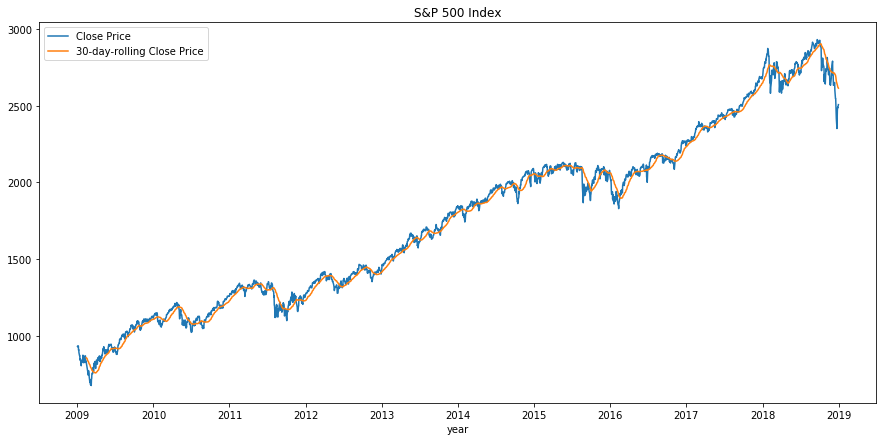

In [10]:
plt.figure(figsize=(15,7))
plt.plot_date(data['Date'], data['Close Price'], '-')
plt.plot_date(data['Date'], data['Close Price'].rolling(30).mean(), '-')
plt.title('S&P 500 Index')
plt.legend(['Close Price', '30-day-rolling Close Price'])
plt.xlabel('year')
plt.show()

### Train / Test Split

根據題目要求：

* Training Set 爲 2009/1/2 到 2017/12/29

* Test Set 爲 2018/1/2 到 2018/12/31


Training Set 共 2264 筆資料

Test Set 共 252 筆資料

In [11]:
train = data[data['year'] < 2018]
test = data[data['year'] == 2018]

In [12]:
train.shape

(2264, 11)

In [13]:
test.shape

(252, 11)

### Feature Selection

* Open Price: 開盤價

* Close Price: 收盤價

* High Price: 期間最高價

* Low Price: 期間最低價

* Volume: 交易數量

因爲每一個 feature 的 range 有所不同，所以進行標準化

預測的 Ground Truth 就是資料集中的 Target

In [14]:
train_x = train[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]
train_y = train['target']
test_x = test[['Open Price', 'Close Price', 'High Price', 'Low Price', 'Volume']]
test_y = test['target']

In [15]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)

std_train_x = scaler.transform(train_x)
std_test_x = scaler.transform(test_x)

## 0. Baseline

如果對全部結果預測 True， 準確率爲 0.5238

In [11]:
baseline_pred = [True] * len(test_y)
print(accuracy_score(test_y, baseline_pred))

0.5238095238095238


## 1. Logistic Regression

使用全部默認的參數設定

In [12]:
from sklearn.linear_model import LogisticRegression

logi_model = LogisticRegression()
_ = logi_model.fit(std_train_x, train_y)

### Testing

這個 Model 很不準，只有 0.5238 的準確度

In [13]:
logi_pred = logi_model.predict(std_test_x)
print(accuracy_score(test_y, logi_pred))

0.5238095238095238


有趣的是， 0.5238 跟 Baseline 是一樣的！

看一下 Logistic regression 預測的結果，果然幾乎全部都預測爲 1

In [14]:
logi_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### 嘗試修改 Class Weight

把 class weight 改成 balanced，因爲資料集中有 54% （>50%）是 1，調整 class weight 可以解決分類類型不平衡問題

**但結果反而更差**

In [15]:
logi_model = LogisticRegression(class_weight='balanced')
_ = logi_model.fit(std_train_x, train_y)

In [16]:
logi_pred = logi_model.predict(std_test_x)
print(accuracy_score(test_y, logi_pred))

0.4880952380952381


### 嘗試用少一點 feature 

說不定有一些 feature 太復雜造成反效果？

試着只用 'Open Price' 和 'Close Price'

準確率有提高一些

In [31]:
logi_model = LogisticRegression()
_ = logi_model.fit(train[['Open Price', 'Close Price']], train_y)
logi_pred = logi_model.predict(test[['Open Price', 'Close Price']])
print(accuracy_score(test_y, logi_pred))

0.5277777777777778


試着只用 'High Price' 和 'Low Price'

準確率反而下降

In [32]:
logi_model = LogisticRegression()
_ = logi_model.fit(train[['High Price', 'Low Price']], train_y)
logi_pred = logi_model.predict(test[['High Price', 'Low Price']])
print(accuracy_score(test_y, logi_pred))

0.5198412698412699


## 2. Support Vector Machine

同樣使用默認的參數設定

In [16]:
from sklearn import svm

svm_model = svm.SVC()
_ = svm_model.fit(std_train_x, train_y)

### Testing

使用 SVM 一樣會發現結果很不準

In [45]:
svm_pred = svm_model.predict(std_test_x)
print(accuracy_score(test_y, svm_pred))

0.5238095238095238


觀察一下 SVM 得出的結果，甚至全部 predict 成 1

In [46]:
svm_pred

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

### 嘗試修改 Kernal 爲 ploy

結果和原本相同，都是0.5283

In [19]:
svm_model = svm.SVC(kernel='poly')
_ = svm_model.fit(std_train_x, train_y)

svm_pred = svm_model.predict(std_test_x)
print(accuracy_score(test_y, svm_pred))

0.5238095238095238


### 嘗試增大 ploy kernel 的 degree

有趣的是，結果仍然相同

In [35]:
svm_model = svm.SVC(kernel='poly', degree=5)
_ = svm_model.fit(std_train_x, train_y)

svm_pred = svm_model.predict(std_test_x)
print(accuracy_score(test_y, svm_pred))

0.5238095238095238


### 用少一點 feature

準確度沒有變化

In [36]:
svm_model = svm.SVC()
_ = svm_model.fit(train[['Open Price', 'Close Price']], train_y)

svm_pred = svm_model.predict(test[['Open Price', 'Close Price']])
print(accuracy_score(test_y, svm_pred))

0.5238095238095238


### 把 penalty 調低

還是沒有任何變化

In [37]:
svm_model = svm.SVC(C=0.05)
_ = svm_model.fit(train[['Open Price', 'Close Price']], train_y)

svm_pred = svm_model.predict(test[['Open Price', 'Close Price']])
print(accuracy_score(test_y, svm_pred))

0.5238095238095238


## 3. Neural Network

搭建一層 Hidden Layer，40 個 units

In [21]:
model = models.Sequential()

model.add(layers.Dense(input_dim=train_x.shape[1],
                       units=40, 
                       activation='relu'))

model.add(layers.Dense(units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
history = model.fit(std_train_x, 
                    train_y, 
                    epochs=50, 
                    validation_data=(std_test_x, test_y),
                    verbose=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 40)                240       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 281
Trainable params: 281
Non-trainable params: 0
_________________________________________________________________


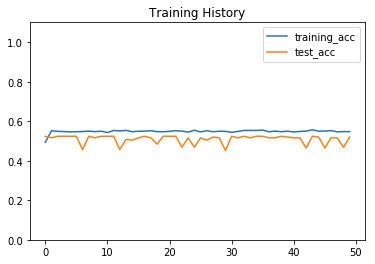

In [22]:
plt.title('Training History')
plt.plot(history.history['acc'])
plt.ylim(0, 1.1)
plt.plot(history.history['val_acc'])
plt.legend(['training_acc', 'test_acc'])

In [23]:
nn_pred = model.predict_classes(std_test_x)
print(accuracy_score(test_y, nn_pred))

0.5198412698412699


發現比 Logistic Regression 和 SVM 的結果還要糟糕

而且模型的 Training Accuracy 無法上升，說明模型正在 Underfitting

### 嘗試加第二層 Hidden Layer

在第二層 Hidden Layer 中加入 100 個 units，避免 Under Fitting

In [24]:
model = models.Sequential()

model.add(layers.Dense(input_dim=train_x.shape[1],
                       units=40, 
                       activation='relu'))

model.add(layers.Dense(units=100, 
                       activation='relu'))

model.add(layers.Dense(units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
history = model.fit(std_train_x, 
                    train_y, 
                    epochs=50, 
                    validation_data=(std_test_x, test_y),
                    verbose=False)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 40)                240       
_________________________________________________________________
dense_4 (Dense)              (None, 100)               4100      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 4,441
Trainable params: 4,441
Non-trainable params: 0
_________________________________________________________________


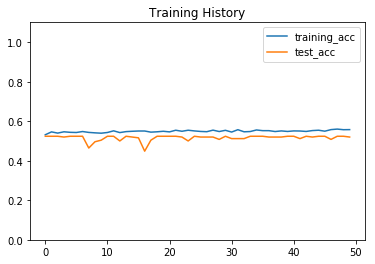

In [25]:
plt.title('Training History')
plt.plot(history.history['acc'])
plt.ylim(0, 1.1)
plt.plot(history.history['val_acc'])
plt.legend(['training_acc', 'test_acc'])

In [26]:
nn_pred = model.predict_classes(std_test_x)
print(accuracy_score(test_y, nn_pred))

0.5198412698412699


出現了十分有趣的結果！

模型仍然在 Under Fitting，但 Neural Network 和 Logistic Regression 還有 SVM 居然產生**一樣的準確率!**

也就是說， Neural Network 也學會全部都 Predict 成 1

In [27]:
nn_pred.reshape(252)

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

## 討論

### 預測結果

有趣的是，Logistic Regression、 SVM 甚至 NN 都給出同樣的預測：

**把所有結果 Predict 成 1 ！**

這樣做最多也只能達到 Base Line Model 的結果

### WHY?

回頭看看數據集，是要預測股票的**漲跌**

股票的漲跌有很多因素影響，像是公司的財報、技術的革命、發布壞消息等等

甚至有人用**混沌理論**來解釋股票市場

基本上現在還沒有人能準確的預測股票的漲跌

在這次的實驗中，僅僅依靠這個數據集少量的 feature 是根本不可能預測股票漲跌的

多層的 Neural Network 都無法很好的 Fit 數據集，由此可見這個數據集其實沒什麼依據或者規律可循

## Extended Question

### 利用過往 4 天的資料預測隔天的股票漲跌

之前只用一天的資料預測隔天的漲跌，每一天只有用到 5 個 Features

一次用過往四天的資料（加上本身一天共 5 天），共 5×5=25 個 features 預測隔天的漲跌

In [28]:
data_5_X = []
data_5_y = []

for index in range(len(data)-6):
    row = []
    
    cur = data.iloc[index+4, 2]
    nxt = data.iloc[index+5, 2]
    
    if nxt >= cur:
        data_5_y.append(1)
    else:
        data_5_y.append(0)
        
    for j in range(index, index+5):
        row.append(list(data.iloc[j, 1:6]))
    
    data_5_X.append(np.array(row).reshape(25))

data_5_y = pd.DataFrame(data_5_y)

In [29]:
data_5_x = pd.DataFrame(data_5_X)

總共合成出 2510 筆資料，每個資料共 25 個 features

In [30]:
data_5_x.shape

(2510, 25)

In [31]:
data_5_y.shape

(2510, 1)

### Train / Test Split

根據原本的 Data， Training Set 共 2264 筆 Data

因爲現在以 5 天爲一組，加上一個預測的Target，所以要減掉 6 組，Training Data 要有 2258 筆


In [32]:
data_5_train_x = data_5_x[:2258]
data_5_train_y = data_5_y[:2258]

data_5_test_x = data_5_x[2258:]
data_5_test_y = data_5_y[2258:]

print(data_5_train_x.shape)
print(data_5_test_x.shape)

(2258, 25)
(252, 25)


### Logistic Regression

又出現這個 0.5238 的數字！

In [33]:
logi_5_model = LogisticRegression()
_ = logi_5_model.fit(data_5_train_x, data_5_train_y)

logi_5_pred = logi_5_model.predict(data_5_test_x)
print(accuracy_score(data_5_test_y, logi_5_pred))

0.5238095238095238


### SVM Model

結果居然一樣是 0.5238 .....

In [34]:
svm_5_model = svm.SVC()
_ = svm_5_model.fit(data_5_train_x, data_5_train_y)

svm_5_pred = svm_5_model.predict(data_5_test_x)
print(accuracy_score(data_5_test_y, svm_5_pred))

0.5238095238095238


### 討論

使用了前幾天的資料作爲新的 Feature 輸入 Model 並沒有作用

更加說明:

1. 股票市場很難預測
2. 僅僅 **合並** 這一些 Feature 不足以預測股票市場

## Another Dataset

因爲預測股票的 Dataset 三個模型的表現 **都一樣** 所以換一個 Dataset 來比較三種模型的差異

### Titanic Dataset

使用著名的 [Titanic Dataset](https://www.kaggle.com/c/titanic/data)，並參考之前 [Decision Tree 練習](https://github.com/IKMLab/FDA-practice-Decision-Tree/blob/master/decision_tree_sklearn.ipynb) 的 Preprocess 方法

簡介：使用艙等，性別，年齡，伴侶數量，票價等等 feature 預測在 Titanic 的事故中是否存活下來

In [35]:
df = pd.read_csv('titanic.csv')

# Drop Useless
df = df.drop('PassengerId', axis = 1)
df = df.drop('Name', axis = 1)
df = df.drop('Ticket', axis = 1)
df = df.drop('Cabin', axis = 1)
df = df.drop('Embarked', axis = 1)

# Fill NULL
age = df['Age']
avgage = age.sum(axis = 0, skipna = True) /len(age)
df['Age'].fillna(avgage, inplace = True)

# Deal Sex
sex_map = {'male' : 0, 'female' :1}
df['Sex'] = df['Sex'].map(sex_map)

df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare
0,0,3,0,22.0,1,0,7.2500
1,1,1,1,38.0,1,0,71.2833
2,1,3,1,26.0,0,0,7.9250
3,1,1,1,35.0,1,0,53.1000
4,0,3,0,35.0,0,0,8.0500


In [36]:
train_x = df[:700].drop('Survived', 1)
train_y = df['Survived'][:700]

test_x = df[700:].drop('Survived', 1)
test_y = df['Survived'][700:]

In [37]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train_x)

std_train_x = scaler.transform(train_x)
std_test_x = scaler.transform(test_x)

### 1. Logistic Regression

使用默認參數，Logistic Regression 做到 0.816 的準確度

In [38]:
logi_model = LogisticRegression()
_ = logi_model.fit(train_x, train_y)

logi_pred = logi_model.predict(test_x)
print(accuracy_score(test_y, logi_pred))

0.8167539267015707


做了標準化之後準確率一樣，猜想是因爲 Logistic Regression 的 Implementation 有先做 L2 Norm 的關系

In [39]:
logi_model = LogisticRegression()
_ = logi_model.fit(std_train_x, train_y)

logi_pred = logi_model.predict(std_test_x)
print(accuracy_score(test_y, logi_pred))

0.8167539267015707


### 2. SVM

使用默認參數，SVM 做到 0.717 的準確度

In [40]:
svm_model = svm.SVC()
svm_model.fit(train_x, train_y)

svm_pred = svm_model.predict(test_x)
print(accuracy_score(test_y, svm_pred))

0.7172774869109948


如果做了標準化， SVM 可以將準確率提高到 0.85

In [44]:
svm_model = svm.SVC()
svm_model.fit(std_train_x, train_y)

svm_pred = svm_model.predict(std_test_x)
print(accuracy_score(test_y, svm_pred))

0.8534031413612565


### 3. Neural Network

使用兩層 Hidden Layer，每層中各有 20 個 unit

如果不先做標準化，準確率只有 0.80

In [42]:
model = models.Sequential()

model.add(layers.Dense(input_dim=train_x.shape[1],
                       units=20, 
                       activation='relu'))

model.add(layers.Dense(units=40, 
                       activation='relu'))


model.add(layers.Dense(units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
history = model.fit(train_x, 
                    train_y, 
                    epochs=50, 
                    validation_data=(test_x, test_y),
                    verbose=False)

nn_pred = model.predict_classes(test_x)
print(accuracy_score(test_y, nn_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_7 (Dense)              (None, 40)                840       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 41        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
0.806282722513089


如果做了標準化，準確率上升到 0.85

In [43]:
model = models.Sequential()

model.add(layers.Dense(input_dim=train_x.shape[1],
                       units=20, 
                       activation='relu'))

model.add(layers.Dense(units=40, 
                       activation='relu'))


model.add(layers.Dense(units=1,
                       activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()
history = model.fit(std_train_x, 
                    train_y, 
                    epochs=50, 
                    validation_data=(std_test_x, test_y),
                    verbose=False)

nn_pred = model.predict_classes(std_test_x)
print(accuracy_score(test_y, nn_pred))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 20)                140       
_________________________________________________________________
dense_10 (Dense)             (None, 40)                840       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 41        
Total params: 1,021
Trainable params: 1,021
Non-trainable params: 0
_________________________________________________________________
0.8586387434554974


### 討論

各模型準確率比較：

1. Neural Network: 0.8586
2. SVM: 0.8543
3. Logistic Regression: 0.8167

個人看法：

* Neural Network 能 Predict 最準其實不意外，畢竟它的參數最多，最有能力'學習'資料集
* 對於 SVM 和 NN 來說，一開始對資料集的標準化很重要，因爲資料集常常不同 feature 有不同的 range
* 如果再對 Dataset 做更細致的 Feature Engineering，會獲得更好的結果